# Solving Optimal Stopping problems using LCP:


## Introduction:

An optimal stopping problem is a problem that requires an agent to choose an optimal stopping time in order to maximize (or minimize) some value.

An example of a simple optimal stopping problem is choosing the optimal shut-down time of a plant. Given a state variable $x_t$, continuing the plant's operations at time $t$ one obtains profit $u(x_t)$ discounted by $e^{-\rho t}$, where $\rho$ is the discount factor. While choosing to shut down the plant at time $t=\tau$ one no longer ooptains any profits from the plant, however, one obtains a one time profit of $S(x_{\tau})$ discounted by $e^{-\rho \tau}$. We can think of this value $S(x_{\tau})$ as the profit from liquidating the assets of the plant. 

To make this problem simple, we can assume that $x_t$ is exogenous, that is, the agent has no control over $\{x_{t}\}_{t=0}^{\infty}$. 

We could for instance consider the case where $x_t$ follows a Brownian diffusion

$$x_t = \mu(x_t)dt + \sigma(x_t)dW_t$$

To ensure that the plant will eventually shut down, we consider the case where $\mu(x) < 0$ for all $x$. 

Thus, we can formulate the optimal stopping problem as:

$$v(x) = \max_{\tau}\mathbb{E}_0\int_{0}^{\tau}e^{-\rho t} u(x_t)dt + e^{-\rho \tau}S(x_{\tau}),\hspace{1cm} dx_t = \mu(x_t)dt+\sigma(x_t)dt$$



## Hamilton-Jacobi Bellman Variational Inequality

For values of $x$ such that the plant does not exit, the following HJB equation holds

$$\rho v(x) = u(x) + \mu(x)v'(x) + \frac{\sigma^2(x)}{2}v''(x)$$

Define $X$ to be the set of $x$ for which there is no exit. Then

- $x\in X: v(x)\geq S(x)\hspace{1cm} $ (i.e the value of not exiting, $v(x)$, is at least as great as the value of exiting $S(x)$)

- $x\notin X: v(x) = S(x)\hspace{1cm}$ (i.e. the maximum possible value, $v(x)$, is the value of choosing to exit, $S(x)$ 

Which then leads to:

- $x\in X: v(x)\geq S(x), \rho v(x) = u(x)+\mu(x)v'(x) +\frac{\sigma^2(x)}{2}v''(x)$

- $x\notin X$: v(x) = S(x), \rho v(x) \geq u(x)+\mu(x)v'(x) +\frac{\sigma^2(x)}{2}v''(x)$


This can be written compactly as a HJB variational inequality:

$$\min\{\rho v(x) - u(x)-\mu(x)v'(x) -\frac{\sigma^2(x)}{2}v''(x), v(x) - S(x)\} = 0$$

## Solving the HJBVI as a Linear Complementarity Problem

Without the exit option the HJB can be discretized as

$$\rho v_i^n = u_i + \mu_i(v_i^n)' + \frac{\sigma^2_i}{2}(v_i^n)''$$

Denoting the differential operator on $v$ by $A$, we can equivalently write the above as

$$ \rho v = u + Av$$

Hence we can rewrite the earlier HJBVI in discretized form:

$$\min\{\rho v - u - Av, v- S\} = 0$$

Furthermore, this the above HJBVI can be equivalently written as:

- $(v-S)^T(\rho v - u - Av) = 0$

- $v\geq S$

- $\rho v - u - Av\geq 0 $

Noting the form of an LCP in the appendix, we can rewrite the above problem as follows.

Denote the "excess value" $z =  v - S$, $B = \rho I - A$, and $q = -u + BS$.

Then problem can be written as:

- $z^T(Bz + q) = 0$

- $z \geq 0$ 

- $Bz+q \geq  0$  

This is the standard form for LCPs (as denoted in the appendix). We can thus proceed to solve this problem, obtaining a solution $z$, using a LCP solver. From there, we can obtain a solution to our original problem $v = z + S$. 

Reference: Ben Moll's notes "Exercising an Option: Numerical Solution"

## Example Problem

We are given an optimal stopping problem:

$$v(x) = \max_{\tau}\mathbb{E}_0\int_{0}^{\tau}e^{-\rho t} u(x_t)dt + e^{-\rho \tau}S(x_{\tau}),\hspace{1cm} dx_t = \mu(x_t)dt+\sigma(x_t)dt$$

where the parameters of the stochastic process, discount factor, utility, and stopping-value are:

- $\mu(x) = -0.01x$ for all $x$
- $\sigma^2(x) = (0.01x)^2$
- $S(x)= 10$ for all $x$ 
- $\gamma = 0.5$ where $u(x)  = x^\gamma$ 
- $\rho = 0.05$

We will also discretize the problem on the interval $[0.01, 1.0]$ utilizing $1000$ grid points.

We create the stopping problem below:

In [2]:
using Parameters, LinearAlgebra

StoppingProblem = @with_kw (μ_bar = -0.01, 
                            σ_bar = 0.01, 
                            S_bar = 10.0, 
                            γ = 0.5, # u(x) = x^γ
                            ρ = 0.05, # discount rate
                            x_min = 0.01,
                            x_max = 1.0,
                            M = 1000) # num of grid points 

#4 (generic function with 2 methods)

Let's also copy the discretization method from [PTW](https://github.com/jlperla/PerlaTonettiWaugh.jl/commits/master/src/utils/diffusionoperators.jl). This is for a reflecting barrier at each boundary. 

-- in order to create the linear operator for the discretized problem. 

In [3]:
# Diffusion operators with regular grids
function diffusionoperators(x::AbstractRange; ξ = 0.0) # ξ = 0.0 corresponds to the unrescaled case from PTW
    Δ = step(x)
    P = length(x)

    dl_1 = zeros(P-1)
    d_1 = -ones(P)
    du_1 = ones(P-1)
    d_1[end] = d_1[end] + du_1[end] * (1-ξ*Δ)
    L_1_plus = Tridiagonal(dl_1, d_1, du_1)/Δ

    dl_m1 = -ones(P-1)
    d_m1 = ones(P)
    du_m1 = zeros(P-1)
    d_m1[1] = d_m1[1] + dl_m1[1] * (1+ξ*Δ)
    L_1_minus = Tridiagonal(dl_m1, d_m1, du_m1)/Δ

    dl_2 = ones(P-1)
    d_2 = -2 * ones(P)
    d_2[1] = -2 + (1+ξ*Δ)
    d_2[end] = -2 + (1-ξ*Δ)
    du_2 = ones(P-1)
    L_2 = Tridiagonal(dl_2, d_2, du_2)/(Δ^2)

    return (x, L_1_minus, L_1_plus, L_2)
end

diffusionoperators (generic function with 1 method)

### Approach 1: Simplest LCP with PATHSolver.jl
-------

Here, we consider the case with constrant drift $\mu(x) = \bar{\mu}$, stopping value $S(x) \equiv \bar{S}$, and variance $\sigma(x) = \bar{\sigma}$.

First, here's a function to take model parameters and return LCP objects.

In [4]:
function LCP_objects(sp)
    # setup work 
    @unpack μ_bar, σ_bar, S_bar, γ, ρ, x_min, x_max, M = sp 
    grid = range(x_min, x_max, length = M)
    tmp, L_1_minus, L_1_plus, L_2 = diffusionoperators(grid) 
    μ = μ_bar 
    S = x -> S_bar 
    u = x -> x^γ # L36 from MATLAB
    σ = σ_bar 
    # construct objects
    A = μ * L_1_minus + 1/2 * σ^2 * L_2 # stochastic generator. use L_1_minus because drift is always negative
    B = ρ*I - A 
    S_vec = S.(grid)
    -u.(grid)
    q_vec = -u.(grid) + B*S_vec
    # return 
    return (A = A, B = B, S = S_vec, q = q_vec)
end

LCP_objects (generic function with 1 method)

Let's generate these objects for the default case.

In [5]:
sp = StoppingProblem()
@unpack A, B, S, q = LCP_objects(sp);

This suggests the following linear complementarity problem:

$$ 
\begin{align}
z'(\mathbf{B}z + q) &= 0 \\ 
z &\geq 0 \\ 
\mathbf{B}z + q &\geq 0
\end{align}
$$

Let's give it to PATHSolver.

In [6]:
using PATHSolver

In [7]:
f = z -> B*z + q
n = sp.M
lb = zeros(n)
ub = 1000*ones(n) # a reasonable guess?
options(convergence_tolerance = 1e-12, output = :no, time_limit = 600) # 10 minute budget
@time exit_code, sol_z, sol_f = solveLCP(f, lb, ub)

  1.484931 seconds (3.40 M allocations: 197.787 MiB, 4.39% gc time)
Reading options file path.opt
 > convergence_tolerance 1.0e-12
Read of options file complete.

1000 row/cols, 2998 non-zeros, 0.30% dense.

Path 4.7.03 (Thu Jan 24 15:44:12 2013)
Written by Todd Munson, Steven Dirkse, and Michael Ferris

 ** EXIT - other error.


(:StationaryPointFound, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.6867, 7.69559, 7.70406, 7.71202, 7.71937, 7.72598, 7.73171, 7.73638, 7.73977, 7.74162], [0.4, 0.395162, 0.390538, 0.386101, 0.381831, 0.37771, 0.373723, 0.369858, 0.366105, 0.362454  …  -3.58602e-14, 1.84297e-14, -7.07212e-14, 2.39808e-14, -3.58602e-14, 5.09592e-14, 8.43769e-14, -1.4877e-14, 7.63833e-14, 5.68434e-14])

Let's generate these objects for the default case.

In [8]:
exit_code # this lets us handle logic like converged(exit_code) || error("foobar")

:StationaryPointFound

Now, we can unpack the solutions and plot them.

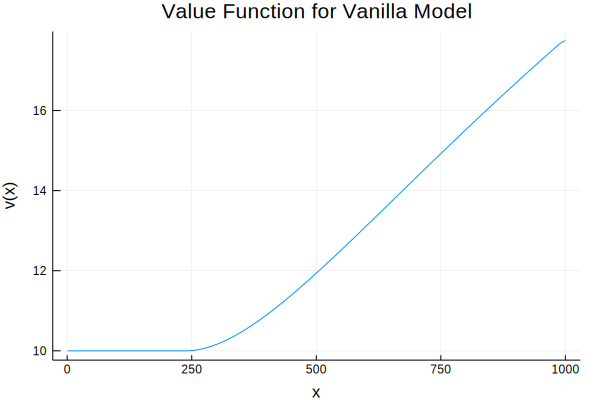

In [13]:
using Plots
v = sol_z + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

This is the kind of thing we expect --- below some threshold you get the stopping value $S \equiv 10$, and above it you get a smoothly increasing value.

## Appendix 

### LCP Problems:

Source Wikipedia